# CPSC 330 - Applied Machine Learning 

## Homework 7: Clustering and recommender systems
### Associated lectures: Lectures 14 and 15

**Due date: Thursday, June 16, 2022 at 18:00**

In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.cluster import DBSCAN, KMeans
from sklearn.feature_extraction.text import CountVectorizer

pd.set_option("display.max_colwidth", 0)

<br><br><br><br>

## Instructions 
<hr>
rubric={points:2}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2022s/blob/master/docs/homework_instructions.md).

**You may work with a partner on this homework and submit your assignment as a group.** Below are some instructions on working as a group.
- The maximum group size is 2.
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

<br><br><br><br>

## Exercise 1: Document clustering toy example <a name="1"></a>
<hr>

In lecture 14, we looked at a popular application of clustering: customer segmentation. In this homework, we will work on another popular application, [**document clustering**](https://en.wikipedia.org/wiki/Document_clustering). A large amount of unlabeled text data is available out there (e.g., news, recipes, online Q&A), and clustering is a commonly used technique to organize this data in a meaningful way. 

In this exercise, we will create a toy dataset with sentences from Wikipedia articles and cluster these sentences. In the next exercise, we'll move to a real corpus.  

### 1.1 Sample sentences from Wikipedia articles
rubric={points:2}

The code below extracts first sentences of Wikipedia articles on a set of queries. You will need the `wikipedia` package installed in the course environment to run the code below. 

```
conda install -n cpsc330 -c conda-forge wikipedia
```

You also need `nltk` library in the course environment.

```
conda install -n cpsc330 -c anaconda nltk 
```

**Your tasks:**

Run the code below and answer the following question. 

1. Given this dataset, how many clusters would you expect a clustering algorithm to identify? How would you manually label these clusters?   

> *Note: Feel free to experiment with queries of your choice. But stick to the provided list for the final submission so that it's easier for the TAs when they grade your submission.*


In [2]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download("punkt")

[nltk_data] Downloading package punkt to /Users/emilymiu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
import wikipedia

queries = [
    "Orange Tree",
    "Grapefruit Tree",
    "Hexagon Shape",
    "English Language",
    "German Language",
    "Planet Jupiter",
    "Planet Venus"
]

wiki_dict = {"wiki query": [], "text": [], "n_words": []}
for i in range(len(queries)):
    sent = sent_tokenize(wikipedia.page(queries[i]).content)[0]
    wiki_dict["text"].append(sent)
    wiki_dict["n_words"].append(len(word_tokenize(sent)))
    wiki_dict["wiki query"].append(queries[i])

wiki_df = pd.DataFrame(wiki_dict)
wiki_df

,wiki query,text,n_words
0,Orange Tree,"Citrus × sinensis (sometimes written Citrus sinensis), also known as the sweet oranges, is a commonly cultivated family of oranges that includes blood oranges and navel oranges.",32
1,Grapefruit Tree,"The grapefruit (Citrus × paradisi) is a subtropical citrus tree known for its relatively large, sour to semi-sweet, somewhat bitter fruit.",26
2,Hexagon Shape,"In geometry, a hexagon (from Greek ἕξ, hex, meaning ""six"", and γωνία, gonía, meaning ""corner, angle"") is a six-sided polygon or 6-gon.",36
3,English Language,"English is a West Germanic language of the Indo-European language family, originally spoken by the inhabitants of early medieval England.",22
4,German Language,"German (Deutsch, pronounced [dɔʏtʃ] (listen)) is a West Germanic language of the Indo-European language family, mainly spoken in Central Europe.",29
5,Planet Jupiter,Jupiter is the fifth planet from the Sun and the largest in the Solar System.,16
6,Planet Venus,Venus is the second planet from the Sun and is named after the Roman goddess of love and beauty.,20


Given this dataset, I would expect a clustering algorithm to identify 4 clusters. I would manually label these clusters by examining which queries are similar to each other and which ones are different by looking at the name and text to find similarities in the use of words and sentence structure. Here I can identify four clusters: sentences about fruits, sentences about shapes, sentences about languages, and sentences about planets.

<br><br>

### 1.2 `KMeans` with bag-of-words representation 
rubric={points:4}

We have seen that before we pass text to machine learning models, we need to encode it into a numeric representation. So let's encode our toy dataset above (`wiki_df`) to a numeric representation. 

First, let's try our good old friend: bag-of-words representation. The code below creates dense bag-of-words representation of Wikipedia sentences from 1.1 with [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). 

**Your tasks:**

Run the code below and answer the following questions. 

1. Run `KMeans` clustering on the transformed data (`bow_sents`) with K = the number of clusters you identified in 1.1.  
2. Examine clustering labels assigned by `KMeans`. Is `KMeans` doing a reasonable job in clustering the sentences? 

> You can access cluster label assignments using `labels_` attribute of the clustering object. 

In [4]:
vec = CountVectorizer(stop_words='english')
bow_sents = vec.fit_transform(wiki_df["text"]).toarray()
bow_df = pd.DataFrame(
    data=bow_sents, columns=vec.get_feature_names_out(), index=wiki_df.index
)
bow_df

,angle,beauty,bitter,blood,central,citrus,commonly,corner,cultivated,deutsch,...,spoken,subtropical,sun,sweet,tree,venus,west,written,γωνία,ἕξ
0,0,0,0,1,0,2,1,0,1,0,...,0,0,0,1,0,0,0,1,0,0
1,0,0,1,0,0,2,0,0,0,0,...,0,1,0,1,1,0,0,0,0,0
2,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
6,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [5]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(bow_sents)
kmeans.predict(bow_sents)
kmeans.labels_

array([3, 2, 1, 0, 0, 1, 1], dtype=int32)

KMeans is doing a reasonable job in clustering the sentences because it correctly grouped the language sentences into cluster 0 and the planet sentences into a new cluster 1. However, it incorrectly labeled the shape sentence into the same cluster as the planets and it grouped the fruit sentences into two separate clusters. 

<br><br>

### 1.3 Sentence embedding representation
rubric={points:6}

Clustering is sensitive to what kind of representation we use for the given data. 
Bag-of-words representation is limited in that it does not take into account word ordering and context. There are other richer representations of text, and we are going to use one such representation in this exercise. 

The code below creates an alternative and a more expressive representation of sentences. We will call it *sentence embedding representation*. We'll use [sentence transformer](https://www.sbert.net/index.html) to extract these representations. At this point it's enough to know that this is an alternative representation of text which usually works better than simple bag-of-words representation. We will talk a bit more about embedding representations next week. You need to install `sentence-transformers` in the course conda environment to run the code below. 

`conda install -n cpsc330 -c conda-forge sentence-transformers`

**Your tasks:**

Run the code below and answer the following questions. 

1. How many dimensions (features associated with each example) are present in this representation? 
2. Run `KMeans` clustering with sentence embedding representation of text (`emb_sents`) and examine cluster labels. 
3. How well the sentences are clustered together? 

In [6]:
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer("paraphrase-distilroberta-base-v1")

/opt/miniconda3/envs/cpsc330/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
emb_sents = embedder.encode(wiki_df["text"])
emb_sent_df = pd.DataFrame(emb_sents, index=wiki_df.index)
emb_sent_df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.169782,0.328721,0.349129,0.160305,-0.001064,-0.042220,0.046996,0.344551,-0.096110,0.152744,...,-0.094106,0.167671,0.087162,0.102412,0.103286,0.154070,-0.714122,0.529451,-0.081597,-0.048938
1,-0.246986,0.277209,0.370583,0.099333,-0.366400,0.168401,0.050352,0.403484,-0.127596,0.240493,...,0.015462,-0.115215,0.469176,0.050542,0.079377,0.094788,0.277293,0.399704,0.103588,0.113049
2,0.245753,0.292600,-0.055407,0.269905,-0.148924,0.058779,0.037858,0.228930,0.197867,0.406216,...,0.219568,-0.411549,0.049736,0.020908,-0.085819,0.009363,-0.614289,0.260229,0.796774,-0.098542
3,-0.043948,0.300679,0.027356,0.522667,0.220695,0.083797,-0.030243,0.330987,0.268973,0.128816,...,0.284563,-0.215861,-0.218333,0.225387,0.346727,0.372262,0.022652,0.249070,-0.032098,0.186563
4,-0.152196,0.336464,-0.008689,0.666325,0.257241,0.056739,0.087526,0.288248,0.229120,0.134044,...,0.661956,0.099084,0.201528,0.048990,0.381907,0.439366,0.009868,-0.068023,0.136935,0.291595
5,-0.124167,0.215485,0.013106,0.143410,-0.636150,0.189037,0.114603,0.075671,0.000973,-0.188108,...,-0.520294,-0.052253,0.358862,0.229728,0.129429,0.416512,-0.039958,0.330362,-0.018109,0.152335
6,0.071988,0.221728,0.100429,0.005925,-0.170285,-0.222389,0.293238,0.210782,0.178689,0.293481,...,-0.117664,-0.079962,0.315055,0.144472,0.180411,0.390725,0.426488,0.154363,0.143687,-0.082053


768 features are present in this representation.

In [8]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(emb_sents)
kmeans.predict(emb_sents)
kmeans.labels_

array([3, 3, 0, 2, 2, 1, 1], dtype=int32)

The sentences are clustered together very well as the sentences that are similar are in the appropriate clusters. The fruit sentences are in one cluster (3), the language sentences are in another cluster (2), and the planet sentences are in a third cluster (1). That leaves the single shape sentence in a fourth cluster (0).

<br><br>

### 1.4 DBSCAN with cosine distance  
rubric={points:8}

Let's try `DBSCAN` on our toy dataset. K-Means is kind of bound to the Euclidean distance because it is based on the notion of means. With `DBSCAN` we can try different distance metrics. In the context of text (sparse data), [cosine similarities](https://scikit-learn.org/stable/modules/metrics.html#cosine-similarity) or cosine distances tend to work better. Given vectors $u$ and $v$, the **cosine distance** between the vectors is defined as: 

$$distance_{cosine}(u,v) = 1 - (\frac{u \cdot v}{\left\lVert u\right\rVert_2 \left\lVert v\right\rVert_2})$$

In this exercise, you'll use DBSCAN with cosine distances. 

**Your tasks**

1. Use DBSCAN to cluster our toy data using sentence embedding representation (`emb_sents`) and `metric='cosine'`. 
2. Briefly comment on the number of clusters identified and the cluster assignment given by the algorithm.

> *Note: You will also have to set appropriate values for the hyperparamters `eps` and `min_samples` to get meaningful clusters, as default values for these hyperparameters won't work on this toy dataset. In order to set appropriate value for `eps`, you may want to examine the distances given by [sklearn's `cosine_distance`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_distances.html).*

In [9]:
dbscan = DBSCAN(eps=0.42, min_samples=2, metric='cosine')
dbscan.fit(emb_sents)
dbscan.labels_

array([ 0,  0, -1,  1,  1,  2,  2])

Three clusters are identified with DBSCAN. Cluster 0 is for the fruit sentences, cluster 1 is for the language sentences, and cluster 2 is for the planet sentences. -1 label represents the shape sentence, which is unassigned to a cluster.

<br><br>

### 1.5 Visualizing clusters 
rubric={points:5}

One thing we could do with unlabeled data is visualizing it. That said, our data is high dimensional (each example is represented with 768 dimensions) and high-dimensional data is hard to visualize. One way to visualize high-dimensional data is applying dimensionality reduction to get the most important (2 or 3) components of the dataset and visualizing this low-dimensional data. 

Given data as a `numpy` array and cluster assignments, the `plot_pca_clusters` function below transforms the given data by applying dimensionality reduction and plots the transformed data into corresponding clusters. 

> *Note: At this point we are using this function only for visualization and you are not expected to understand the PCA part. Feel free to modify the function as you see fit.*

**Your tasks:**

1. Call the function `plot_pca_clusters` to visualize the clusters created by the three models above:
    - KMeans with bag-of-words representation 
    - KMeans with sentence embedding representation. 
    - DBSCAN with sentence embedding representation. 

In [10]:
from sklearn.decomposition import PCA # Obtain the principal components

def plot_pca_clusters(
    data,
    cluster_labels,
    raw_sents=wiki_df["text"],
    show_labels=False,
    size=100,
    title="PCA visualization",
):
    """
    Carry out dimensionality reduction using PCA and plot 2-dimensional clusters.

    Parameters
    -----------
    data : numpy array
        data as a numpy array
    cluster_labels : list
        cluster labels for each row in the dataset
    raw_sents : list
        the original raw sentences for labeling datapoints
    show_labels : boolean
        whether you want to show labels for points or not (default: False)
    size : int
        size of points in the scatterplot
    title : str
        title for the visualization plot

    Returns
    -----------
    None. Shows the clusters.
    """

    pca = PCA(n_components=2)
    principal_comp = pca.fit_transform(data)
    pca_df = pd.DataFrame(data=principal_comp, columns=["pca1", "pca2"])
    pca_df["cluster"] = cluster_labels

    plt.figure(figsize=(10, 7))
    plt.title(title)
    ax = sns.scatterplot(
        x="pca1", y="pca2", hue="cluster", data=pca_df, palette="tab10", s=size
    )

    x = pca_df["pca1"].tolist()
    y = pca_df["pca2"].tolist()
    if show_labels:
        for i, txt in enumerate(raw_sents):
            plt.annotate(" ".join(txt.split()[:10]), (x[i], y[i]))
        ax.legend(loc="upper right")

    plt.show()

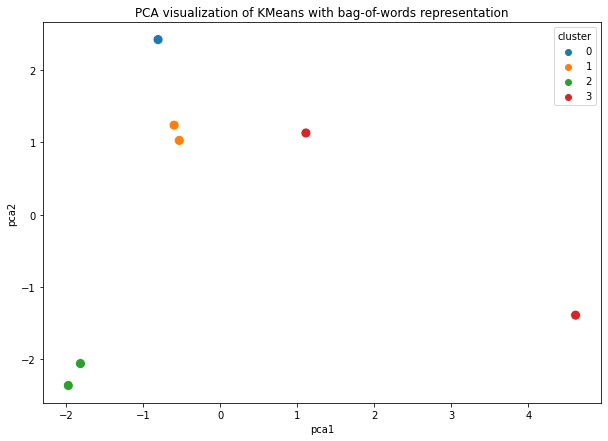

In [11]:
plot_pca_clusters(
    bow_sents,
    kmeans.labels_,
    raw_sents=wiki_df["text"],
    show_labels=False,
    size=100,
    title="PCA visualization of KMeans with bag-of-words representation",
)

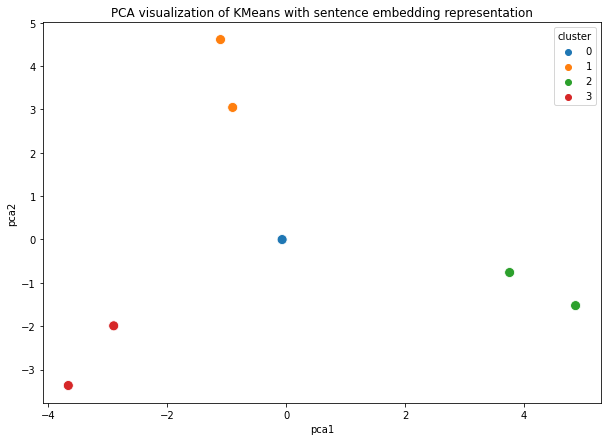

In [12]:
plot_pca_clusters(
    emb_sents,
    kmeans.labels_,
    raw_sents=wiki_df["text"],
    show_labels=False,
    size=100,
    title="PCA visualization of KMeans with sentence embedding representation",
)

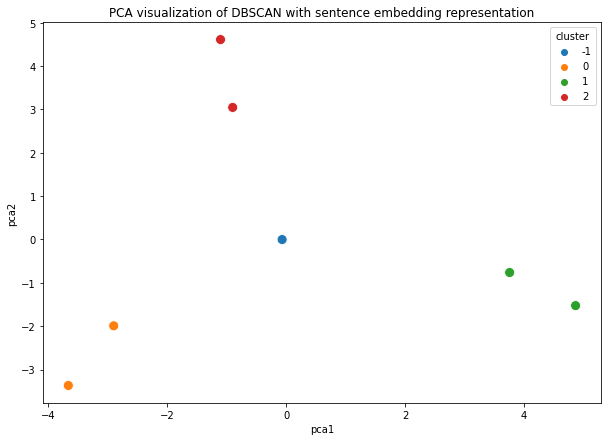

In [13]:
plot_pca_clusters(
    emb_sents,
    dbscan.labels_,
    raw_sents=wiki_df["text"],
    show_labels=False,
    size=100,
    title="PCA visualization of DBSCAN with sentence embedding representation",
)

<br><br><br><br>

## Exercise 2: Movie recommendations
<hr>

Let's build simple movie recommendation systems using the [MovieLens dataset](https://www.kaggle.com/prajitdatta/movielens-100k-dataset/data). The original source of the data is [here](https://grouplens.org/datasets/movielens/), and the structure of the data is described in the [README](http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html) that comes with it. The code below reads the data as a CSV assuming that it's under `ml-100k/` directory under your homework folder.

In [14]:
r_cols = ["user_id", "movie_id", "rating", "timestamp"]
ratings = pd.read_csv(
    os.path.join("ml-100k", "u.data"),
    sep="\t",
    names=r_cols,
    encoding="latin-1",
)
ratings.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [15]:
# We'll be using these keys later in the starter code
user_key = "user_id"
item_key = "movie_id"

### 2.1 Terminology
rubric={points:3}

Here is some notation we will be using in this homework. 

**Constants**:

 - $N$: the number of users, indexed by $n$
 - $M$: the number of movies, indexed by $m$
 - $\mathcal{R}$: the set of indices $(n,m)$ where we have ratings in the utility matrix $Y$
    - Thus $|\mathcal{R}|$ is the total number of ratings
 
**The data**:

 - $Y$: the utility matrix containing ratings, with a lot of missing entries
 - `train_mat` and `valid_mat`: Utility matrices for train and validation sets, respectively
 
    
**Your tasks:**    

1. What are the values of $N$ and $M$ in movie ratings data?  
2. What would be the shape of the dense utility matrix $Y$? 
3. What would be the fraction of non missing ratings in the utility matrix $Y$? 

In [16]:
N = len(np.unique(ratings[user_key]))
M = len(np.unique(ratings[item_key]))

print("Number of users (N): %d" % N)
print("Number of items (M): %d" % M)
print("Shape of dense utility matrix (Y): (" + str(N) + ", " + str(M) + ")")
print("Fraction non-nan ratings: %0.3f" % (len(ratings) / (N * M)))

Number of users (N): 943
Number of items (M): 1682
Shape of dense utility matrix (Y): (943, 1682)
Fraction non-nan ratings: 0.063


<br><br>

### 2.2 Splitting the data
rubric={points:5}

**Your tasks:**

1. Split the ratings data with `test_size=0.2` and `random_state=42`. 

In [17]:
from sklearn.model_selection import train_test_split

X = ratings.copy()
y = ratings[user_key]  
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

<br><br>

### 2.3 Utility matrix 
rubric={points:10}

**Your tasks**
1. Create utility matrices for train and validation sets. 
2. Briefly explain the difference between the train and validation utility matrices. 

> You may use the code from lecture notes with appropriate attributions.  

> You won't do it in real life but since our dataset is not that big, create a dense utility matrix in this assignment. You are welcome to try sparse matrix but then you may have to change some started code provided in the later exercises.  

In [18]:
user_mapper = dict(zip(np.unique(ratings[user_key]), list(range(N))))
item_mapper = dict(zip(np.unique(ratings[item_key]), list(range(M))))
user_inverse_mapper = dict(zip(list(range(N)), np.unique(ratings[user_key])))
item_inverse_mapper = dict(zip(list(range(M)), np.unique(ratings[item_key])))

# from lecture 15
def create_Y_from_ratings(data, N, M):
    Y = np.zeros((N, M))
    Y.fill(np.nan)
    for index, val in data.iterrows():
        n = user_mapper[val[user_key]]
        m = item_mapper[val[item_key]]
        Y[n, m] = val["rating"]

    return Y

In [19]:
train_mat = create_Y_from_ratings(X_train, N, M)
valid_mat = create_Y_from_ratings(X_valid, N, M)

The difference between the train and validation utility matrices is that train_mat has only ratings from the train set and valid_mat has only ratings from the valid set because during training we do not have access to some of the available ratings, so we predict these ratings and evaluate them against ratings in the validation set.

<br><br>

### 2.4 Evaluation and baseline
rubric={points:4}

To compare different models you build in this homework, let's write a couple of functions for evaluation. 
- The `error` function returns RMSE.
- The `evaluate` function prints the train and validation RMSEs. 

**Your task:**

1. Briefly explain what exactly we are comparing to evaluate recommender systems. 
2. Implement the global average baseline, where you predict everything as the global average rating. What's the RMSE of the global average baseline?

We are comparing the actual ratings and predicted ratings by calculating the error between them using the RMSE metric to evaluate recommender systems.

In [20]:
def error(Y1, Y2):
    """
    Returns the root mean squared error (RMSE).
    """
    return np.sqrt(np.nanmean((Y1 - Y2) ** 2))


def evaluate(pred_Y, train_mat, valid_mat, model_name="Global average"):
    print("%s train RMSE: %0.2f" % (model_name, error(pred_Y, train_mat)))
    print("%s valid RMSE: %0.2f" % (model_name, error(pred_Y, valid_mat)))

In [21]:
# from lecture 15
avg = np.nanmean(train_mat)
pred_g = np.zeros(train_mat.shape) + avg
pd.DataFrame(pred_g).head()

,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
0,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,...,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262
1,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,...,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262
2,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,...,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262
3,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,...,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262
4,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,...,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262


In [22]:
evaluate(pred_g, train_mat, valid_mat, model_name="Global average")

Global average train RMSE: 1.13
Global average valid RMSE: 1.12


<br><br>

### (Optional) 2.5 $k$-nearest neighbours imputation
rubric={points:1}

**Your tasks:**

Try [KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html) to fill in the missing entries. Discuss your observations. 

In [ ]:
# from lecture 15
from sklearn.impute import KNNImputer

results_dict = {}
neighbours = [10, 15, 20, 25, 30]

for n in neighbours:
    imputer = KNNImputer(n_neighbors=n)
    train_mat_imp = imputer.fit_transform(train_mat)
    results_dict["n_neighbours: " + str(n)] = pd.DataFrame(train_mat_imp)

results_dict

{'n_neighbours: 10':        0    1    2    3    4    5    6    7    8    9  ...  1643  1644  1645  \
 0    4.0  3.0  4.0  3.7  3.0  3.8  4.0  3.3  5.0  3.0  ...  3.0   3.0   1.0    
 1    4.0  3.0  3.3  4.1  3.2  4.3  4.4  4.4  4.5  4.1  ...  3.0   3.0   1.0    
 2    3.8  3.2  2.8  3.1  3.5  3.5  4.0  3.7  3.7  4.3  ...  3.0   3.0   1.0    
 3    4.1  2.9  3.9  3.1  3.6  3.8  3.3  4.3  4.2  4.2  ...  3.0   3.0   1.0    
 4    4.0  3.0  3.3  3.8  3.3  4.1  4.0  3.8  3.8  4.1  ...  3.0   3.0   1.0    
 ..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...    
 938  3.8  3.7  3.7  3.5  4.0  4.1  4.0  3.9  5.0  4.3  ...  3.0   3.0   1.0    
 939  4.1  3.2  3.6  2.0  3.3  3.6  3.7  4.1  3.0  4.3  ...  3.0   3.0   1.0    
 940  5.0  3.4  2.9  3.8  3.3  3.6  4.3  3.8  4.5  3.6  ...  3.0   3.0   1.0    
 941  4.2  3.4  3.6  3.4  4.0  4.0  3.5  4.3  4.0  4.0  ...  3.0   3.0   1.0    
 942  4.3  5.0  3.2  3.6  3.3  4.0  3.7  4.4  3.0  4.1  ...  3.0   3.0   1.0    
 
      

The new matrices formed after imputation have less columns than the original utility matrix because KNNImputer removes all the columns with all NaN values. The shape before imputing was (943, 1682), but now it is (943, 1653).

<br><br>

### 2.6 Use collaborative filtering with the `surprise` package
rubric={points:6}

Use the [`surprise`](https://surprise.readthedocs.io/en/stable/) package which has implementation of SVD algorithm for collaborative filtering. You can install it as follows in your conda environment. 

`conda install -n cpsc330 -c conda-forge scikit-surprise`

**Your tasks:**

1. Carry out cross-validation using SVD algorithm in the package, similar to how we did it in the lecture on Jester dataset. Report mean RMSE and compare it with global baseline. 

In [ ]:
# from lecture 15
import surprise
from surprise import SVD, Dataset, Reader, accuracy

ratings_surprise = ratings.drop(["timestamp"], axis=1)
reader = Reader()
data = Dataset.load_from_df(ratings_surprise, reader)  


trainset, validset = surprise.model_selection.train_test_split(
    data, test_size=0.2, random_state=42
)  

k = 10
svd_algo = SVD(n_factors=k, random_state=42)
svd_algo.fit(trainset)
svd_preds = svd_algo.test(validset)
accuracy.rmse(svd_preds, verbose=True)

from surprise.model_selection import cross_validate

results = cross_validate(svd_algo, data, measures=["RMSE", "MAE"], cv=5, verbose=True)
pd.DataFrame(results).mean()

RMSE: 0.9328
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9386  0.9323  0.9391  0.9385  0.9318  0.9360  0.0033  
MAE (testset)     0.7428  0.7357  0.7405  0.7391  0.7369  0.7390  0.0025  
Fit time          1.77    1.93    1.75    1.99    1.79    1.85    0.10    
Test time         0.14    0.13    0.11    0.11    0.12    0.13    0.01    


test_rmse    0.936049
test_mae     0.738988
fit_time     1.846936
test_time    0.125040
dtype: float64

The mean RMSE is 0.9360, whereas the RMSE for the global baseline is 1.12. This is lower than the global baseline's RMSE which tells us that the model is not overfitting and can fit the dataset well.

<br><br><br><br>

## Exercise 3: Short answer questions
<hr>

rubric={points:5}

Answer the following short-answer questions: 

1. What's the main difference between unsupervised and supervised learning?
2. When choosing $k$ in $k$-means, why not just choose the $k$ that leads to the smallest inertia (sum of squared distances within clusters)?
3. You decide to use clustering for _outlier detection_; that is, to detect instances that are very atypical compared to all the rest. How might you do this with $k$-means?
4. You decide to use clustering for _outlier detection_; that is, to detect instances that are very atypical compared to all the rest. How might you do this with DBSCAN?
5. How might you apply clustering to recommendation systems? 

1. The main difference between unsupervised and supervised learning is that in supervised learning we have labeled data and in unsupervised learning we have unlabeled data. We do not have a target class in unsupervised learning.

2. We cannot just choose the $k$ that leads to the smallest inertia because the inertia decreases as K increases. For example, if number of clusters equals number of examples, each example will have its own cluster and the intra-cluster distance will be 0.

3. With $k$-means, each cluster is represented by a center. We assign each example to the closest center and estimate new centers as an average of observations in a cluster or until centers stop changing or maximum iterations have reached. This iterative process can detect outliers as it updates the center every step, allowing us to visualize which points are not close to it.

4. We can detect outliers by increasing eps because either more points will be included in a cluster or noise points will be created. We can also increase min_samples since points in less dense regions will either be labeled as their own cluster or noise.

5. We can apply clustering to recommendation systems by using $k$-means or DBSCAN to find new recommendations for something through observing a user's past preferences based on a center. When we assign new points to a center, it can represent a new recommendation we create to offer a user. This can increase the diversity, consistency, and reliability of recommendations, as well as the data sparsity of user-preference matrices and changes in user preferences over time. 

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 